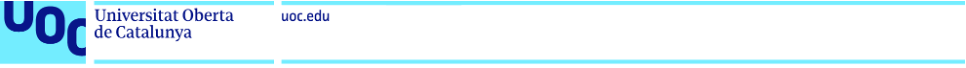

# Comparativa entre redes neuronales convolucionales y redes antagónicas generativas para el mejoramiento de la resolución de imágenes


Autor: **Carlos J. Guzmán Güell**<br>
Plan de Estudios: Grado en Ingeniería Informática<br>
Área del trabajo final: Inteligencia Artificial

Consultor: **Joan M. Núñez Do Río**<br>
Profesor responsable de la asignatura: **Dr. Xavier Baró Solé**

---

# Arquitectura GAN

In [1]:
# ------------------------------------------------------------------------------
# Imports
# ------------------------------------------------------------------------------
import os
import sys
import shutil
import time

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array

# ------------------------------------------------------------------------------
# Notebook constants
# ------------------------------------------------------------------------------
# Training constants
EPOCHS = 200
BATCH_SIZE = 8
generator_model_name = f'gan_for_superresolution_generator_{EPOCHS}_epochs'
discriminator_model_name = f'gan_for_superresolution_discriminator_{EPOCHS}_epochs'

# Paths
path_to_repo = 'cnn-gan-superresolution'
path_to_models = f'{path_to_repo}/models/*.py'
path_to_utils = f'{path_to_repo}/utils/*.py'
path_to_dataset = f'{path_to_repo}/data/BSDS500/*'

#path_to_save_results = './gan-results'
path_to_save_results = '/content/drive/MyDrive/cnn-results'

path_to_generator_model = f'{path_to_save_results}/{generator_model_name}.h5'
path_to_generator_training_metrics = f'{path_to_save_results}/{generator_model_name}_training_metrics.csv'
path_to_generator_validation_metrics = f'{path_to_save_results}/{generator_model_name}_validation_metrics.csv'

path_to_discriminator_model = f'{path_to_save_results}/{discriminator_model_name}.h5'
path_to_discriminator_training_metrics = f'{path_to_save_results}/{discriminator_model_name}_training_metrics.csv'
path_to_discriminator_validation_metrics = f'{path_to_save_results}/{discriminator_model_name}_validation_metrics.csv'

# ------------------------------------------------------------------------------
# Setup
# ------------------------------------------------------------------------------
if os.path.exists(path_to_repo):
    shutil.rmtree(path_to_repo)

!git clone https://github.com/Carlos0196/cnn-gan-superresolution.git

# Copy models to workspace
!cp $path_to_models .

# Copy utils to workspace
!cp $path_to_utils .

# Copy data to workspace
!cp -R $path_to_dataset .

# Scripts imports
from constants import *
from data_preprocessing import *
from visualization import *
from metrics import *
from generator import *
from discriminator import *

print('\n*******************************************')
print('**               Finished                **')
print('*******************************************')
print('\nCopied scripts:')
!ls | grep '**\.py' | nl

Cloning into 'cnn-gan-superresolution'...
remote: Enumerating objects: 750, done.
remote: Counting objects: 100% (239/239), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 750 (delta 74), reused 223 (delta 58), pack-reused 511
Receiving objects: 100% (750/750), 70.40 MiB | 13.07 MiB/s, done.
Resolving deltas: 100% (75/75), done.
Updating files: 100% (617/617), done.

*******************************************
**               Finished                **
*******************************************

Copied scripts:
     1	constants.py
     2	data_preprocessing.py
     3	discriminator.py
     4	generator.py
     5	metrics.py
     6	visualization.py




---


# Conjuntos de datos

Este estudio utiliza el conjunto de datos [BSDS500](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html).

En este apartado se separan las imágenes en:

1.   Conjunto de entrenamiento
2.   Conjunto de validación
3.   Conjunto de test

A cada conjunto se le ha realizado un preprocesamiento que consta de tomar las imágenes de alta resolución y redimensionarlas a imágenes de 300x300px, esto facilita su uso durante el entrenamiento.

Después de esto, se procede a realizar una redimensión nuevamente para obtener las imágenes de baja resolución de 100x100px que servirán de entrada para el modelo.

Finalmente, se puede observar una muestra de las imágenes ya tratadas.

Found 200 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 200 files belonging to 1 classes.


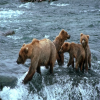

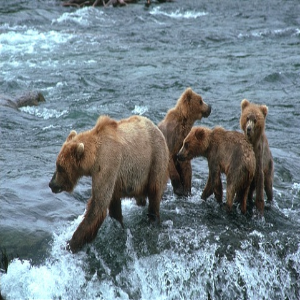

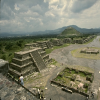

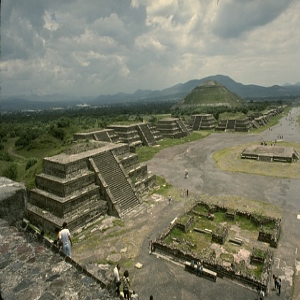

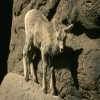

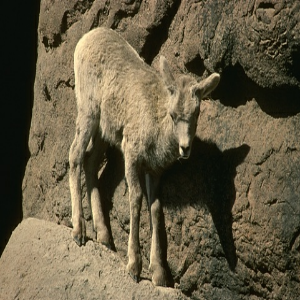

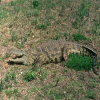

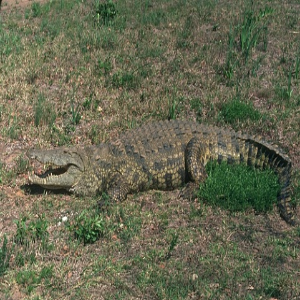

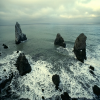

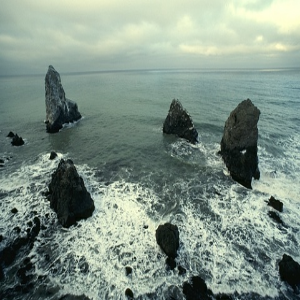

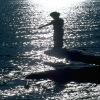

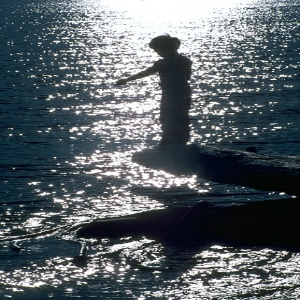

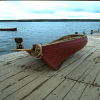

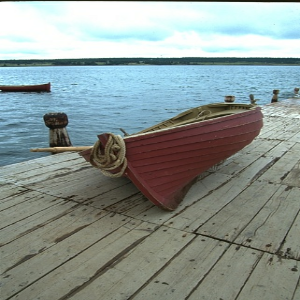

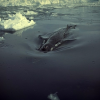

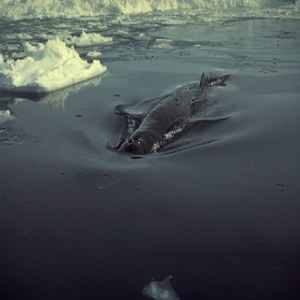

In [2]:
train_ds, valid_ds, test_ds = get_data_sets(BATCH_SIZE)

def show_batch():
  for batch in train_ds.take(1):
    for i in range(len(batch[0])):
      display(array_to_img(batch[0][i]))
      display(array_to_img(batch[1][i]))

show_batch()



---


# Función de pérdida y optimizador

Para la función de pérdida se utilizará *BinaryCrossentropy*.

Para el optimizador, Adam con un *learning rate* de $\eta = 0.0002$

In [3]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Genetator optimizer
generator_optimizer = tf.keras.optimizers.Adam(2e-4)

# Discriminator optimizer
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)



---


# Entrenamiento

En este apartado se definen las funciones que harán el entrenamiento del modelo.

El entrenamiento incluye cálculo de métricas (MSE, SSIM y PSNR) que se almacenarán en un *dataframe* de la librería pandas. Además se mostrarán imágenes tras cada cuarto del entrenamiento, de esta manera se prodrá apreciar el estado entrenamiento.

In [4]:
# This annotation causes the function to be "compiled".
@tf.function
def train_step(generator, discriminator, batch):
    low_res_images = batch[0]
    high_res_images = batch[1]

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate images
        output = generator(low_res_images, training=True)

        # Send images to discriminator
        real_output = discriminator(high_res_images, training=True)
        fake_output = discriminator(output, training=True)

        # Calculate loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Optimize models
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(train_ds, valid_ds, epochs, generator, discriminator):
  df_train_gen = pd.DataFrame()
  df_valid_gen = pd.DataFrame()

  df_train_dis = pd.DataFrame()
  df_valid_dis = pd.DataFrame()

  # Epoch
  for epoch in range(epochs):
    start = time.time()

    ############################################################################
    #                             Training                                     #
    ############################################################################
    # Batch
    metrics_data = []
    metrics_data_discriminator = []
    for image_batch in train_ds:
      # Train on batch
      train_step(generator, discriminator, image_batch)
      
      # Batch metrics - Generator
      batch_metrics = calc_batch_metrics(generator, image_batch)
      metrics_data.extend(batch_metrics)

      # Batch metrics - Discriminator
      batch_metrics = calc_batch_metrics_disc(generator, discriminator, image_batch)
      metrics_data_discriminator.extend(batch_metrics)

    # Epoch metrics
    df_train_gen_epoch = create_epoch_dataframe(f'EPOCH_{epoch+1}', DF_COLUMNS, metrics_data)
    df_train_gen = pd.concat([df_train_gen, df_train_gen_epoch], axis=1)

    df_train_dis_epoch = create_epoch_dataframe(f'EPOCH_{epoch+1}', DF_COLUMNS_DISCRIMINATOR, metrics_data_discriminator)
    df_train_dis = pd.concat([df_train_dis, df_train_dis_epoch], axis=1)

    ############################################################################
    #                             Validation                                   #
    ############################################################################
    # Batch
    metrics_data = []
    metrics_data_discriminator = []
    for image_batch in valid_ds:
      # Batch metrics - Generator
      batch_metrics = calc_batch_metrics(generator, image_batch)
      metrics_data.extend(batch_metrics)

      # Batch metrics - Discriminator
      batch_metrics = calc_batch_metrics_disc(generator, discriminator, image_batch)
      metrics_data_discriminator.extend(batch_metrics)

    # Epoch metrics
    df_valid_gen_epoch = create_epoch_dataframe(f'EPOCH_{epoch+1}', DF_COLUMNS, metrics_data)
    df_valid_gen = pd.concat([df_valid_gen, df_valid_gen_epoch], axis=1)

    df_valid_dis_epoch = create_epoch_dataframe(f'EPOCH_{epoch+1}', DF_COLUMNS_DISCRIMINATOR, metrics_data_discriminator)
    df_valid_dis = pd.concat([df_valid_dis, df_valid_dis_epoch], axis=1)

    # Produce images after each training quarter
    if epochs >= 4:
      if (epoch + 1) % (epochs // 4) == 0:
        show_sample_images(epoch, generator, path_to_save_results)

    ############################################################################
    #                             Statistics                                   #
    ############################################################################
    total_time = time.time()-start
    epoch_statistics(epoch, df_train_gen_epoch, df_valid_gen_epoch, total_time)

  # Produce images after the final epoch
  show_sample_images(epochs, generator, path_to_save_results)

  return df_train_gen, df_valid_gen, df_train_dis, df_valid_dis

Una vez definido el entrenamiento, se procede a crear una instancia del modelo generador y del modelo discriminador y se comienza el proceso.

In [5]:
# Create generator model
gen_model = make_generator_model()

# Create discriminator model
dis_model = make_discriminator_model()

In [ ]:
# Start training
df_train_gen, df_valid_gen, df_train_dis, df_valid_dis = train(train_ds, valid_ds, EPOCHS, gen_model, dis_model)



*******************************************
**                EPOCH 1                **
*******************************************
Time for epoch 1 is 78.56 sec

Training dataset - Mean
---------------------------------------
BIC_MSE      243.415115
GEN_MSE     3548.918213
BIC_SSIM       0.761016
GEN_SSIM       0.157705
BIC_PSNR      25.397266
GEN_PSNR      13.039066
dtype: float32

Training dataset - Standard deviation
---------------------------------------
BIC_MSE      206.966034
GEN_MSE     1487.766479
BIC_SSIM       0.096961
GEN_SSIM       0.113074
BIC_PSNR       3.219548
GEN_PSNR       1.963607
dtype: float32

Validation dataset - Mean
---------------------------------------
BIC_MSE      244.662933
GEN_MSE     2467.930420
BIC_SSIM       0.740681
GEN_SSIM       0.308276
BIC_PSNR      25.092215
GEN_PSNR      14.653394
dtype: float32

Validation dataset - Standard deviation
---------------------------------------
BIC_MSE      154.048126
GEN_MSE     1141.801270
BIC_SSIM       0.10



---


# Almacenado de los modelos y las métricas

In [ ]:
############################################################################
#                             Save models                                  #
############################################################################
gen_model.compile()
gen_model.save(path_to_generator_model)
print("Generator Model Saved!")

dis_model.compile()
dis_model.save(path_to_discriminator_model)
print("Discriminator Model Saved!")

############################################################################
#                             Save metrics                                 #
############################################################################
df_train_gen.to_csv(path_to_generator_training_metrics)
df_valid_gen.to_csv(path_to_generator_validation_metrics)
print("Generator Metrics Saved!")

df_train_dis.to_csv(path_to_discriminator_training_metrics)
df_valid_dis.to_csv(path_to_discriminator_validation_metrics)
print("Discriminator Metrics Saved!")



---


# Carga de los modelos y métricas almacenadas

In [ ]:
# Training metrics
loaded_df_train_gen = pd.read_csv(path_to_generator_training_metrics, header=[0,1], index_col=0)
print()
print(loaded_df_train_gen)

# Validation metrics
loaded_df_valid_gen = pd.read_csv(path_to_generator_validation_metrics, header=[0,1], index_col=0)
print()
print(loaded_df_valid_gen)

# Model
loaded_gen_model = load_model(path_to_generator_model)

hr_img = load_img('val/108070.jpg')
lr_img = downscale(hr_img)
gen_img = process_through_model(loaded_gen_model, lr_img)
plot_results(
    gen_img,
    'Test upsample by model',
    [250, 325, 100, 175],
    '.',
    f'Test_loaded_model_epoch_{EPOCHS}'
)



---


# Métricas y resultados

In [ ]:
# funcion que en base al dataframe cree los graficos comparativos